In [1]:
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
import time 

In [7]:
# load data 
mbd_data = pd.read_csv('./outputs/mbd_data.csv')
clusters = json.loads(open('./outputs/clusters_arima.json',"r").read())  # change here clusters_sarima
cluster_keys = ["0","1","2","3","4","5","6","-1"]
mbd_data = mbd_data.sort_values(by=["cfips","first_day_of_month"]).reset_index(drop=True)
mbd_data.median_hh_inc.ffill(inplace=True)
mbd_data.pct_it_workers.ffill(inplace=True)

sc = MinMaxScaler()
mbd_data.median_hh_inc = sc.fit_transform( mbd_data.median_hh_inc.values.reshape(-1,1) ).reshape(-1)

cfips = mbd_data.cfips.unique()

In [3]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_pred) + np.abs(y_true)) / 2
    smape_val = np.mean(numerator / denominator)
    return smape_val

In [4]:
# Plot a county 

def plot_county(cfip):
#     cfip = clusters["-1"][0]
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))
    dates = pd.date_range(start='2019-08-01', end='2022-12-01', freq='MS')
    values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

    # Plot the line
    ax.plot(dates, values)

    # Set the axis labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Microbusiness Density')
    ax.set_title(f'{location} ( CFIP {cfip} )  ')

    # Rotate the x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Show the plot
    plt.show()

In [5]:
# Adfuller Test : Check if for any county, microbusiness density is stationary 

# cfip = clusters["-1"][1]
stationary_count = 0 
stationary_counties = []
for cfip in clusters["-1"]: 
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

    p_value = adfuller(values)[1]
    if p_value < 0.01 : 
        # reject null hypothesis . So time series is stationary 
        stationary_count += 1 
        stationary_counties.append(cfip)
stationary_count, len(clusters["-1"])

(13, 86)

In [232]:
# VAR model fit 
cfip = clusters["-1"][0]
cfip

1035

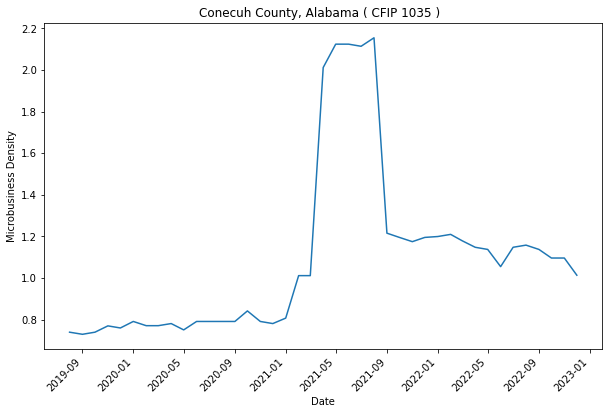

In [233]:
plot_county(cfip)

In [234]:
# mbd_data.head()

In [255]:
columns = ["microbusiness_density","pct_bb","median_hh_inc","pct_college","pct_foreign_born", "pct_it_workers"]
data = mbd_data[mbd_data.cfips == cfip][columns].values
size = 38
train, test = data[:size],data[size:]
model = sm.tsa.VAR(train)
nlags = 1
results = model.fit(maxlags=nlags)
# data

In [256]:
# preds = list(data[:nlags,0])
# for i in range(0,len(test)-nlags):
#     preds.append(results.forecast(data[i:i+nlags], 1)[:,0][0])
true = data[:,0]

preds = list(data[:nlags,0])
for i in range(0,len(train)-nlags):
    preds.append(results.forecast(data[i:i+nlags], 1)[:,0][0])

for i in range(len(train) - nlags, len(data)-nlags):
    last_nlags_predictions = np.array(preds[-nlags:]).reshape(-1,1)
    new_data = np.append( last_nlags_predictions, data[i:i+nlags,1:],axis=1)
    preds.append(results.forecast(new_data, 1)[:,0][0])
    
    
len(preds),len(data)

(41, 41)

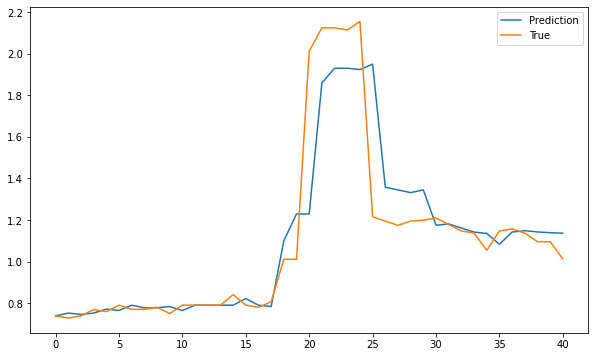

In [257]:
plt.figure(figsize=(10,6))
plt.plot(preds,label="Prediction")
plt.plot(true,label="True")
plt.legend()
plt.show()

In [258]:
smape(true[size:],preds[size:])

0.06535204258261558